In [116]:
import os
import glob
import librosa
from scipy.io import loadmat
from collections import defaultdict
import torch
from tqdm import tqdm
from torch import nn
import re
import math
from pathlib import Path
import matplotlib.pyplot as plt

In [117]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [118]:
def add_first_release_data():

    for entry in os.scandir("Metadata"):
        if not entry.is_dir():
            continue
        
        has_first_release = False
        records = []
        for file in os.scandir(entry.path):
            if not file.is_file():
                continue

            with open(file.path) as f:
                lines = [line.rstrip("\n") for line in f]
                year = lines[2]
                if "," in year:
                    year = year[year.index(","):]
                year = re.sub(r'[^0-9]', '', year)
                lines[2] = year

                records.append({
                    "path": file.path,
                    "lines": lines,
                    "year": int(year)
                })

                if len(lines) >= 4 and "first" in lines[3].lower():
                    has_first_release = True
        
        if has_first_release:
            continue

        earliest = min(records, key=lambda r:r["year"])
        earliest["lines"].append("First release")
        for record in records:
            with open(record["path"], "w") as f:
                f.write("\n".join(record["lines"]) + "\n")



In [119]:
def get_song_info():

    song_dict = defaultdict(dict)

    songs = glob.glob("Metadata/**/*.txt", recursive=True)
    
    for file in tqdm(songs):
        with open(file) as f:
                key1 = file[file.index("/") + 1: file.rindex("/")]
                key2 = file[file.rindex("/") + 1:file.index(".")]
                lines = [line.rstrip("\n") for line in f]
                song_dict[key1][key2] = {"Metadata": lines}
                              
    return song_dict

In [120]:
def get_audio_info(song_dict):

    mfcc_files = glob.glob("MFCCs/**/*.mat", recursive=True)
    cens_files = glob.glob("CENS/**/*.mat", recursive=True)

    for mfcc_file, cens_file in zip(mfcc_files, cens_files):
        mat1 = loadmat(mfcc_file)
        mfcc_matrix = mat1['XMFCC'].squeeze()
        mfcc_matrix = torch.tensor(mfcc_matrix, dtype=torch.float32)
        mean = mfcc_matrix.mean(dim=1)
        std = mfcc_matrix.std(dim=1)
        min_ = mfcc_matrix.min(dim=1).values
        max_ = mfcc_matrix.max(dim=1).values
        mfcc_tensor = torch.cat([mean, std, min_, max_], dim = 0)

        mat2 = loadmat(cens_file)
        cens_matrix = mat2["XCENS"].squeeze()
        cens_matrix = torch.tensor(cens_matrix, dtype=torch.float32)
        mean = cens_matrix.mean(dim=1)
        std = cens_matrix.std(dim=1)
        min_ = cens_matrix.min(dim=1).values
        max_ = cens_matrix.max(dim=1).values
        cens_tensor = torch.cat([mean, std, min_, max_], dim = 0)

        key1 = mfcc_file[mfcc_file.index("/") + 1: mfcc_file.rindex("/")]
        key2 = mfcc_file[mfcc_file.rindex("/") + 1: mfcc_file.index("_")]
        song_dict[key1][key2]["X"] = torch.cat([mfcc_tensor, cens_tensor], dim=0)

    return song_dict



In [121]:
def create_feature_tensor(song_dict):

    X = []
    song_list = []

    for folder in sorted(song_dict):
        for song in sorted(song_dict[folder]):
            song_list.append(song)
            X.append(song_dict[folder][song]["X"])
    X = torch.stack(X)
    return X, song_list

In [122]:
def group_songs_by_feature(song_dict):

    # songs grouped based on when the original was released
    first_release_groupings = {}

    # songs grouped based on when the cover was released
    cover_release_groupings = {}

    # songs grouped by number of covers released
    songs_with_more_than_3_covers = {}

    # first release songs mapped to their corresponding covers
    first_releases_to_covers = {}

    # group songs by number of years since original the cover was made
    year_since_original = {"<2": [], "2-3":[], "3-4":[], "4-5":[], "6-9": [], "10-14": [], "15-19": [], "20-29": [], "30+":[]}

    months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

    for folder in song_dict:
        if len(song_dict[folder]) >=4:
            songs_with_more_than_3_covers[folder] = [song for song in song_dict[folder]]
        for song in song_dict[folder]:
            if ("First release" in song_dict[folder][song]["Metadata"] 
                or "First recording" in song_dict[folder][song]["Metadata"] 
                or "First performance" in song_dict[folder][song]["Metadata"]):
                year = song_dict[folder][song]["Metadata"][2]
                year_data = None
                if " " in year:
                    year_data = year.split()
                if "," in year:
                    year = year[year.index(","):]
                year = re.sub(r'[^0-9]', '', year)
                oldest_song = True
                for tune in song_dict[folder]:
                    if tune != song:
                        year_comp_data = None
                        year_comp = song_dict[folder][tune]["Metadata"][2]
                        if " " in year_comp:
                            year_comp_data = year_comp.split()
                        if "," in year_comp:
                            year_comp = year_comp[year_comp.index(","):]
                        year_comp = re.sub(r'[^0-9]', '', year_comp)
                        year_comp = int(year_comp)
                        time_since = abs(int(year) - year_comp)
                        if year_comp < int(year):
                            if time_since < 2:
                                year_since_original["<2"].append((tune, song))
                            elif 3 > time_since and time_since >= 2:
                                year_since_original["2-3"].append((tune, song))
                            elif 4 > time_since and time_since >= 3:
                                year_since_original["3-4"].append((tune, song))
                            elif 5 > time_since and time_since >= 4:
                                year_since_original["4-5"].append((tune, song))
                            elif 9 > time_since and time_since >= 6:
                                year_since_original["6-9"].append((tune, song))
                            elif 14 > time_since and time_since >= 10:
                                year_since_original["10-14"].append((tune, song))
                            elif 19 > time_since and time_since >= 15:
                                year_since_original["15-19"].append((tune, song))
                            elif 29 > time_since and time_since >= 20:
                                year_since_original["20-29"].append((tune, song))
                            else:
                                year_since_original["30+"].append((tune, song))
                            oldest_song = False
                        elif year_comp == int(year) and year_data and year_comp_data:
                            if months.index(year_comp_data[0]) < months.index(year_data[0]):
                                if ("First release" in song_dict[folder][song]["Metadata"] 
                                    or "First recording" in song_dict[folder][song]["Metadata"] 
                                    or "First performance" in song_dict[folder][song]["Metadata"]) and (
                                        "First release" in song_dict[folder][tune]["Metadata"] 
                                    or "First recording" in song_dict[folder][tune]["Metadata"] 
                                    or "First performance" in song_dict[folder][tune]["Metadata"]
                                    ):
                                    year_since_original["<2"].append((tune, song))
                                    oldest_song = False
                            elif months.index(year_comp_data[0]) == months.index(year_data[0]) and not (("First release" in song_dict[folder][song]["Metadata"] 
                                                                                                or "First recording" in song_dict[folder][song]["Metadata"] 
                                                                                                or "First performance" in song_dict[folder][song]["Metadata"])):
                                year_since_original["<2"].append((tune, song))
                                oldest_song = False
                        if oldest_song:
                            if time_since < 2:
                                year_since_original["<2"].append((song, tune))
                            elif 3 > time_since and time_since >= 2:
                                year_since_original["2-3"].append((song, tune))
                            elif 4 > time_since and time_since >= 3:
                                year_since_original["3-4"].append((song, tune))
                            elif 5 > time_since and time_since >= 4:
                                year_since_original["4-5"].append((song, tune))
                            elif 9 > time_since and time_since >= 6:
                                year_since_original["6-9"].append((song, tune))
                            elif 14 > time_since and time_since >= 10:
                                year_since_original["10-14"].append((song, tune))
                            elif 19 > time_since and time_since >= 15:
                                year_since_original["15-19"].append((song, tune))
                            elif 29 > time_since and time_since >= 20:
                                year_since_original["20-29"].append((song, tune))
                            else:
                                year_since_original["30+"].append((song, tune))
                if oldest_song:
                    first_releases_to_covers[song] = [tune for tune in song_dict[folder] if tune != song]
                if (oldest_song) and f"{year[:3]}0" in first_release_groupings:
                    first_release_groupings[f"{year[:3]}0"].append(song)
                elif (oldest_song) and f"{year[:3]}0" not in first_release_groupings:
                    first_release_groupings[f"{year[:3]}0"] = [song]
                elif not oldest_song:
                    if f"{year[:3]}0" in cover_release_groupings:
                        cover_release_groupings[f"{year[:3]}0"].append(song)
                    else:
                        cover_release_groupings[f"{year[:3]}0"] = [song]
            else:
                year = song_dict[folder][song]["Metadata"][2]
                if "," in year:
                    year = year[year.index(","):]
                year = re.sub(r'[^0-9]', '', year)
                if f"{year[:3]}0" in cover_release_groupings:
                    cover_release_groupings[f"{year[:3]}0"].append(song)
                else:
                    cover_release_groupings[f"{year[:3]}0"] = [song]
    
    for year in year_since_original:
        year_since_original[year] = set(year_since_original[year])

    return (
        first_release_groupings,
        cover_release_groupings,
        songs_with_more_than_3_covers,
        first_releases_to_covers,
        year_since_original
    )


In [123]:
class EmotionRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.net(x)

In [124]:
def evaluate_model(X):

    ckpt = torch.load("emotion_regressor.pt")

    model = EmotionRegressor(ckpt["input_dim"]).to(device)
    model.load_state_dict(ckpt["model_state_dict"])
    X = (X - ckpt["X_mean"]) / ckpt["X_std"]
    model.eval()

    with torch.no_grad():
        preds = model(X)
    
    return preds

In [125]:
def find_cover_distances(originals, song_tensors, original_val, original_aro, d_max):
    
    cover_distances = []

    for cover in originals:
        cover_val = song_tensors[cover][0]
        cover_aro = song_tensors[cover][1]

        distance = math.hypot(cover_val - original_val, cover_aro - original_aro)
        distance = distance / d_max
        cover_distances.append(distance)
    
    distance = sum(cover_distances)/len(cover_distances)
    return distance

In [126]:
def compute_distances(song_list,
                      preds,
                      originals_to_covers, 
                      first_release_groupings, 
                      cover_release_groupings, 
                      song_with_more_than_3,
                      years_since_original):

    global_distance_metrics = {}
    d_max = 2 * math.sqrt(2)
    
    song_tensors = {}
    for i, row in enumerate(preds):
        song_tensors[song_list[i]] = row

    org_to_cover_distances = []
    for original in originals_to_covers:
        original_val = song_tensors[original][0]
        original_aro = song_tensors[original][1]

        cover_distance = find_cover_distances(originals_to_covers[original], song_tensors, original_val, original_aro, d_max)
        org_to_cover_distances.append(cover_distance)

    avg_distance = sum(org_to_cover_distances)/len(org_to_cover_distances)
    global_distance_metrics["overall average distance"] = avg_distance

    distances_by_year = {}
    for year in first_release_groupings:
        distances = []
        for original in first_release_groupings[year]:
            original_val = song_tensors[original][0]
            original_aro = song_tensors[original][1]

            year_distance = find_cover_distances(originals_to_covers[original], song_tensors, original_val, original_aro, d_max)
            distances.append(year_distance)

        distances_by_year[year] = float(f"{sum(distances)/len(distances):.4f}")

    global_distance_metrics["dist by first release year"] = distances_by_year

    covers_distances_by_year = {}
    for year in cover_release_groupings:
        distances = []
        for song in cover_release_groupings[year]:
            cover_val = song_tensors[song][0]
            cover_aro = song_tensors[song][1]

            original = [org for org in originals_to_covers if song in originals_to_covers[org]]
            original_val = song_tensors[original[0]][0]
            original_aro = song_tensors[original[0]][1]

            distance = math.hypot(cover_val - original_val, cover_aro - original_aro)
            distance = distance / d_max
            distances.append(distance)

        covers_distances_by_year[year] = float(f"{sum(distances)/len(distances):.4f}")
    
    global_distance_metrics["dist by cover year"] = covers_distances_by_year

    distances = []
    for folder in song_with_more_than_3:
        cover_preds = []
        cover_distances = []
        for song in song_with_more_than_3[folder]:
            if song in originals_to_covers:
                original_val = song_tensors[song][0]
                original_aro = song_tensors[song][1]
            else:
                cover_val = song_tensors[song][0]
                cover_aro = song_tensors[song][1]
                cover_preds.append((cover_val, cover_aro))
        for cover in cover_preds:
            distance = math.hypot(cover[0] - original_val, cover[1] - original_aro)
            distance = distance / d_max
            cover_distances.append(distance)  
        distance = sum(cover_distances)/len(cover_distances)
        distances.append(distance)

    avg_distance = sum(distances)/len(distances)
    global_distance_metrics["3+ covers avg"] = avg_distance

    time_since_original = {}
    for year in years_since_original:
        distances = []
        for pair in years_since_original[year]:
            cover_val = song_tensors[pair[1]][0]
            cover_aro = song_tensors[pair[1]][1]

            original_val = song_tensors[pair[0]][0]
            original_aro = song_tensors[pair[0]][1]
            distance = math.hypot(cover_val - original_val, cover_aro - original_aro)
            distance = distance / d_max
            distances.append(distance)
        time_since_original[year] = sum(distances)/len(distances)
    global_distance_metrics["years since original"] = time_since_original

    return global_distance_metrics

In [136]:
def full_monty():
    
    add_first_release_data()
    song_dict = get_song_info()
    song_dict = get_audio_info(song_dict)
    X, song_list = create_feature_tensor(song_dict)

    grouped_dictionaries = group_songs_by_feature(song_dict)
    first_release_groupings = grouped_dictionaries[0]
    cover_release_groupings = grouped_dictionaries[1]
    song_with_more_than_3 = grouped_dictionaries[2]
    originals_to_covers = grouped_dictionaries[3]
    years_since_original = grouped_dictionaries[4]
    
    preds = evaluate_model(X)

    distance_dict = compute_distances(song_list,
                                      preds,
                                      originals_to_covers, 
                                      first_release_groupings, 
                                      cover_release_groupings, 
                                      song_with_more_than_3,
                                      years_since_original)

    return preds, song_list, grouped_dictionaries, distance_dict

In [137]:
preds, song_list, grouped_dictionaries, distance_dict = full_monty()

100%|██████████| 998/998 [00:00<00:00, 44428.45it/s]


In [138]:
print(distance_dict)

{'overall average distance': 0.08198157954869427, 'dist by first release year': {'1980': 0.0795, '1950': 0.0919, '2000': 0.0798, '1970': 0.0763, '1990': 0.0843, '2010': 0.0816, '1930': 0.089, '1960': 0.0835, '1940': 0.0406, '1920': 0.0975, '1900': 0.1803}, 'dist by cover year': {'2010': 0.0846, '1970': 0.0722, '1960': 0.0865, '1990': 0.0783, '2000': 0.0876, '1950': 0.0908, '1930': 0.1001, '1980': 0.0776, '1940': 0.1141, '1900': 0.2237}, '3+ covers avg': 0.08877638911732952, 'years since original': {'<2': 0.08328869495084995, '2-3': 0.07942637350736911, '3-4': 0.06809633075212158, '4-5': 0.08336554416463444, '6-9': 0.06936564504459153, '10-14': 0.08800253222532291, '15-19': 0.08069233513578965, '20-29': 0.07929371464795738, '30+': 0.09026047342414509}}


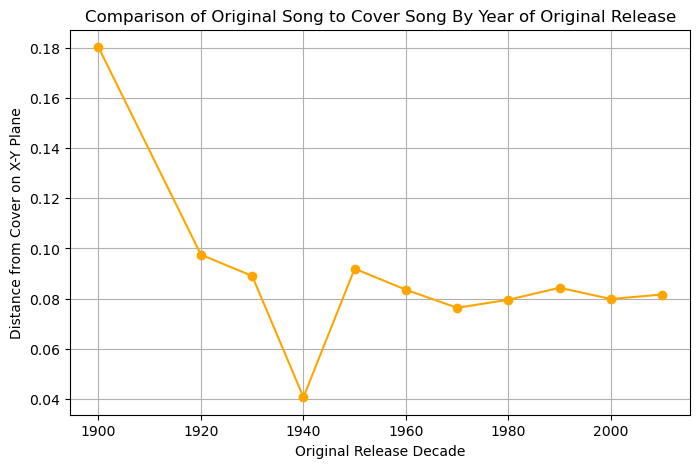

In [156]:
data = {}
for key in distance_dict['dist by first release year']:
    data[int(key)] = distance_dict['dist by first release year'][key]

years = list(sorted(data.keys()))

distance = []
for year in years:
    distance.append(data[year])

plt.figure(figsize=(8, 5))
plt.plot(years, distance, marker='o', linestyle='-', color='orange')
plt.grid(True)
plt.xlabel('Original Release Decade')
plt.ylabel('Distance from Cover on X-Y Plane')
plt.title('Comparison of Original Song to Cover Song By Year of Original Release')

plt.show()

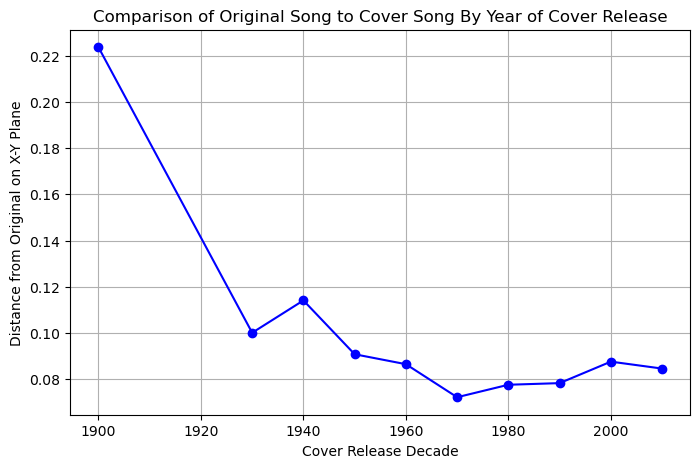

In [157]:
data = {}
for key in distance_dict['dist by cover year']:
    data[int(key)] = distance_dict['dist by cover year'][key]

years = list(sorted(data.keys()))

distance = []
for year in years:
    distance.append(data[year])

plt.figure(figsize=(8, 5))
plt.plot(years, distance, marker='o', linestyle='-', color='b')
plt.grid(True)
plt.xlabel('Cover Release Decade')
plt.ylabel('Distance from Original on X-Y Plane')
plt.title('Comparison of Original Song to Cover Song By Year of Cover Release')

plt.show()

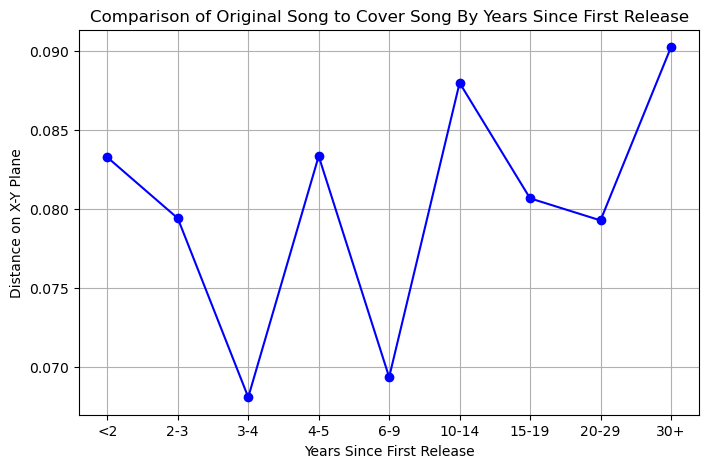

In [158]:
data = distance_dict['years since original']

years = list(data.keys())
distance = list(data.values())

plt.figure(figsize=(8, 5))
plt.plot(years, distance, marker='o', linestyle='-', color='b')
plt.grid(True)
plt.xlabel('Years Since First Release')
plt.ylabel('Distance on X-Y Plane')
plt.title('Comparison of Original Song to Cover Song By Years Since First Release')

plt.show()

In [133]:
# Plots

# 391 - no words
# 368 - cross genre (Bon Jovi to screamo catamenia)
# 327: Grateful Dead to Courtney Barnett
# 307: Interesting piano to brass jazz example
# 313: Funny cover of Only Happy when It Rains by Richard Cheese
# 259: Different song, difficult example with very stylistically different vocals
# 261: Vocal to jazz example (neat!)
# 232: Very strange cover of Fleetwood Mac
# 207: Cross gender
# 156: Jerry Garcia studio (Deal) versus Grateful Dead live
# 182: Cross genre (R&B to reggae)
# 184: Very different instruments
# 127: Difficult example (old vocals not very distinct, needs to rely on pitch)
# 133: Difficult examples (stylistically very different)
# 76: Good Cross Genre
# 8: A good example of where the notes are quite different
# 12: Good example of screamo cross genre

In [ ]:
first_releases_to_covers = grouped_dictionaries[3]

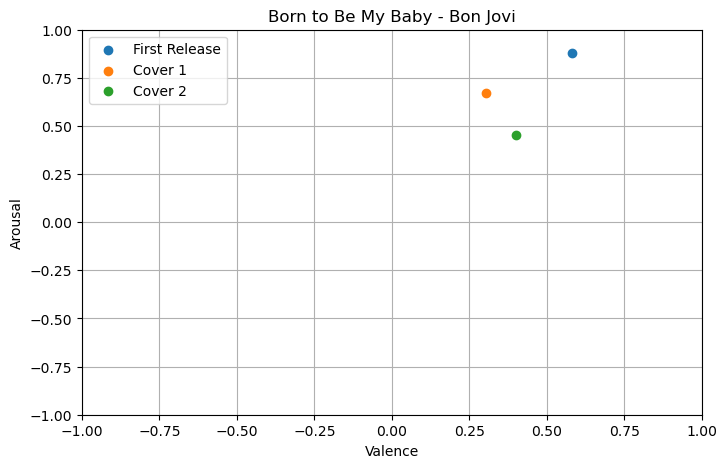

In [ ]:
# 368
bonjovi_covers = first_releases_to_covers['265434']

org_scores = preds[song_list.index('265434')]

plt.figure(figsize=(8, 5))
plt.scatter([org_scores[0]], [org_scores[1]], label="First Release")

for i, cover in enumerate(bonjovi_covers):
    cover_scores = preds[song_list.index(cover)]
    plt.scatter([cover_scores[0]], [cover_scores[1]], label=f"Cover {i + 1}")

plt.legend()
plt.grid(True)
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.title('Born to Be My Baby - Bon Jovi')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.show()

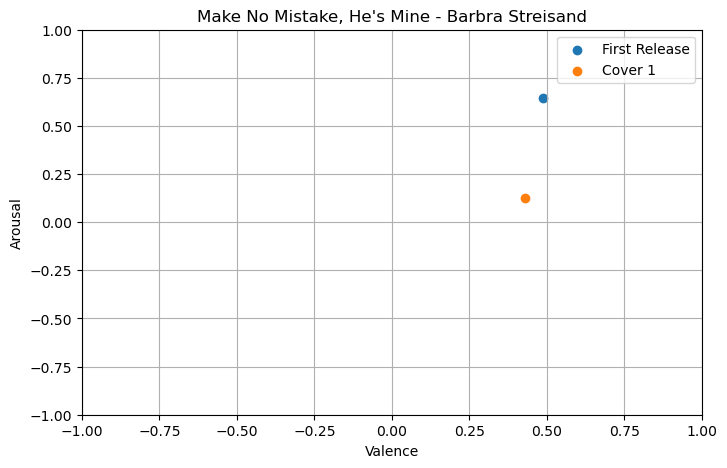

In [ ]:
# 207 - cross gender
barbra_covers = first_releases_to_covers['63718']

org_scores = preds[song_list.index('63718')]

plt.figure(figsize=(8, 5))
plt.scatter([org_scores[0]], [org_scores[1]], label="First Release")

for i, cover in enumerate(barbra_covers):
    cover_scores = preds[song_list.index(cover)]
    plt.scatter([cover_scores[0]], [cover_scores[1]], label=f"Cover {i + 1}")

plt.legend()
plt.grid(True)
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.title("Make No Mistake, He's Mine - Barbra Streisand")
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.show()

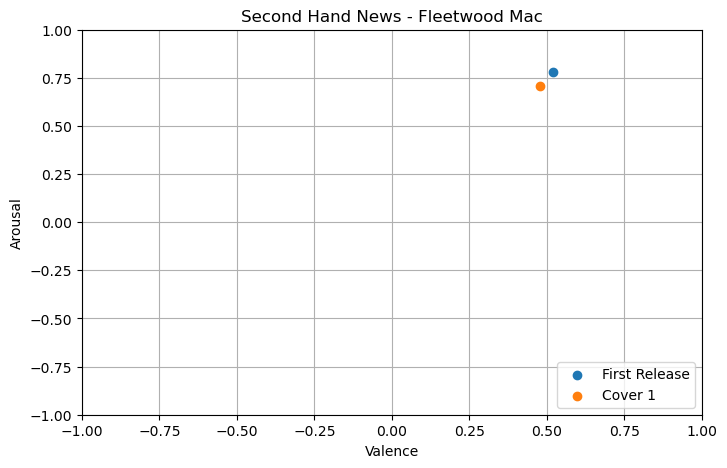

In [ ]:
# 232
mac_covers = first_releases_to_covers['47184']

org_scores = preds[song_list.index('47184')]

plt.figure(figsize=(8, 5))
plt.scatter([org_scores[0]], [org_scores[1]], label="First Release")

for i, cover in enumerate(mac_covers):
    cover_scores = preds[song_list.index(cover)]
    plt.scatter([cover_scores[0]], [cover_scores[1]], label=f"Cover {i + 1}")

plt.legend(loc='lower right')
plt.xlabel('Valence')
plt.grid(True)
plt.ylabel('Arousal')
plt.title("Second Hand News - Fleetwood Mac")
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.show()

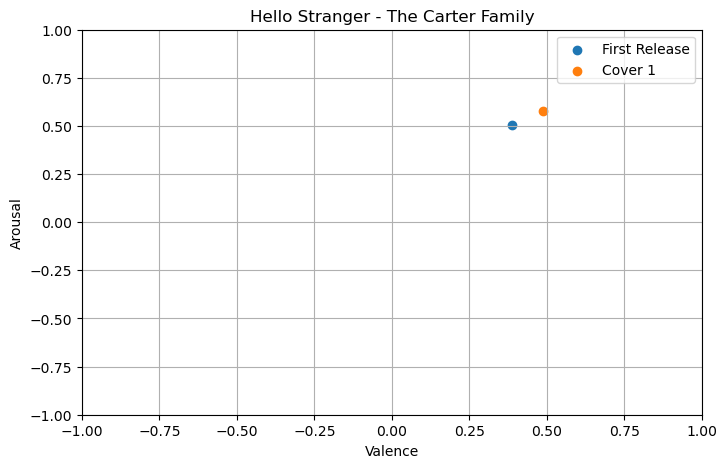

In [163]:
#127
stranger_covers = first_releases_to_covers['15456']

org_scores = preds[song_list.index('15456')]

plt.figure(figsize=(8, 5))
plt.scatter([org_scores[0]], [org_scores[1]], label="First Release")

for i, cover in enumerate(stranger_covers):
    cover_scores = preds[song_list.index(cover)]
    plt.scatter([cover_scores[0]], [cover_scores[1]], label=f"Cover {i + 1}")

plt.legend()
plt.grid(True)
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.title("Hello Stranger - The Carter Family")
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.show()

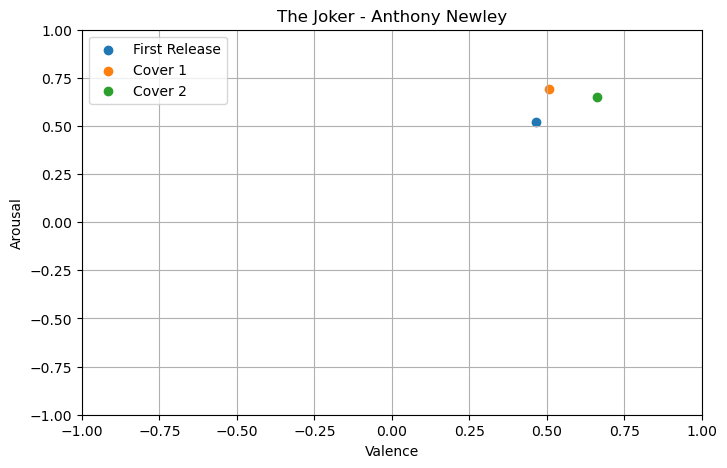

In [164]:
#133
joker_covers = first_releases_to_covers['10255']

org_scores = preds[song_list.index('10255')]

plt.figure(figsize=(8, 5))
plt.scatter([org_scores[0]], [org_scores[1]], label="First Release")

for i, cover in enumerate(joker_covers):
    cover_scores = preds[song_list.index(cover)]
    plt.scatter([cover_scores[0]], [cover_scores[1]], label=f"Cover {i + 1}")

plt.legend()
plt.xlabel('Valence')
plt.grid(True)
plt.ylabel('Arousal')
plt.title("The Joker - Anthony Newley")
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.show()

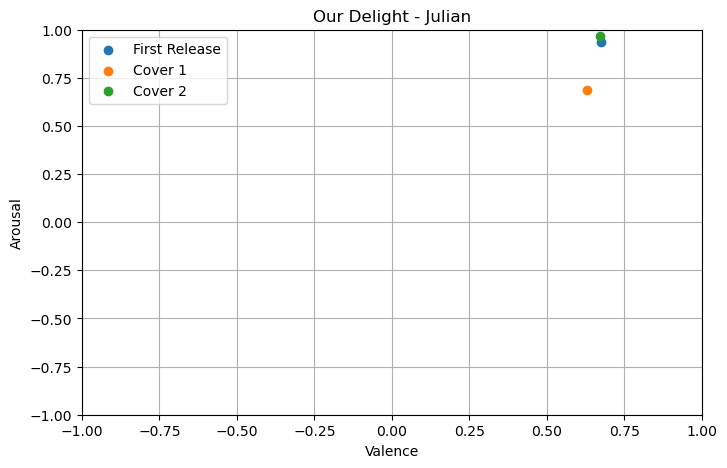

In [165]:
# 307: Interesting piano to brass jazz example
no_words = first_releases_to_covers['439525']

org_scores = preds[song_list.index('439525')]

plt.figure(figsize=(8, 5))
plt.scatter([org_scores[0]], [org_scores[1]], label="First Release")

for i, cover in enumerate(no_words):
    cover_scores = preds[song_list.index(cover)]
    plt.scatter([cover_scores[0]], [cover_scores[1]], label=f"Cover {i + 1}")

plt.legend()
plt.xlabel('Valence')
plt.grid(True)
plt.ylabel('Arousal')
plt.title("Our Delight - Julian")
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.show()


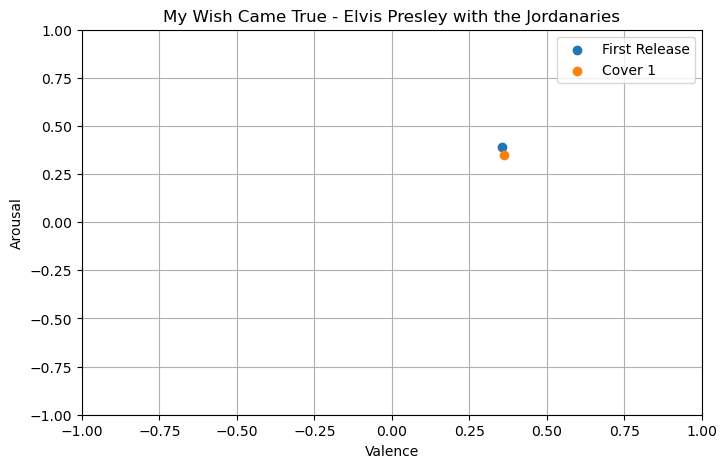

In [166]:
# 22: This is a language translation, so mfcc completely fails!
language_tanslation = first_releases_to_covers['148555']

org_scores = preds[song_list.index('148555')]

plt.figure(figsize=(8, 5))
plt.scatter([org_scores[0]], [org_scores[1]], label="First Release")

for i, cover in enumerate(language_tanslation):
    cover_scores = preds[song_list.index(cover)]
    plt.scatter([cover_scores[0]], [cover_scores[1]], label=f"Cover {i + 1}")

plt.legend()
plt.grid(True)
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.title("My Wish Came True - Elvis Presley with the Jordanaries")
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.show()